
To Do:
1. Integrate the problem for a fixed set of parameters
2. Plot the trajectory
3. Parameterise the path
4. Work out bounds on parameters
5. Run DIRECT over it.


In [237]:
import sympy as sp
import numpy as np

x, dx, ddx = sp.symbols(r'x,\dot{x},\ddot{x}', real=True)
theta, dtheta, ddtheta = sp.symbols(r'\theta,\dot{\theta},\ddot{\theta}', real=True)
u = sp.symbols('u', real=True)
M_c, I, m, b, l, g = sp.symbols('M_c, I , m, b, l, g', real=True, positive=True)

c  = sp.symbols('c:4', positive=True)
subs = [
    (I, c[0] - m * l * l),   # c[0] = I + m l^2
    (l, c[1] / m),           # c[1] = lm
    (m, c[2] - M_c),          # c[2] = M_c + m
    (b, c[3]),
]

dynamics = [
    (M_c + m) * ddx + b*dx + m*l*ddtheta *sp.cos(theta) - m*l*sp.sin(theta) * dtheta**2 - u,
    (I +m*l*l) * ddtheta +m*g*l *sp.sin(theta) +m*l*ddx*sp.cos(theta)
]
dynamics = sp.Matrix([d.subs(subs).expand() for d in dynamics])
dynamics

Matrix([
[\ddot{\theta}*c1*cos(\theta) + \ddot{x}*c2 - \dot{\theta}**2*c1*sin(\theta) + \dot{x}*c3 - u],
[                               \ddot{\theta}*c0 + \ddot{x}*c1*cos(\theta) + c1*g*sin(\theta)]])

In [212]:
# Dynamics
# M(x) dotx = F(x) + G(x)u
#

DX = sp.Matrix([ddx, ddtheta, dx, dtheta])
X = sp.Matrix([dx,dtheta, x, theta])
M = sp.Matrix([[d.coeff(x_i) for x_i in DX] for d in dynamics] +[[0,0,1,0], [0, 0, 0, 1] ] )
G = sp.Matrix([-d.coeff(u) for d in dynamics] + [0, 0])
F = sp.Matrix([-d for d in dynamics] + [0, 0]) - G * u + M @ DX
# We have M @ DX - F - Gu = 0 - > M @ DX = F + Gu



In [238]:
M.inv() @  (F + G*u)

Matrix([
[           -\dot{x}*c0*c3/(c0*c2 - c1**2*cos(\theta)**2) + c0*(\dot{\theta}**2*c1*sin(\theta) + u)/(c0*c2 - c1**2*cos(\theta)**2) + c1**2*g*sin(\theta)*cos(\theta)/(c0*c2 - c1**2*cos(\theta)**2)],
[\dot{x}*c1*c3*cos(\theta)/(c0*c2 - c1**2*cos(\theta)**2) - c1*c2*g*sin(\theta)/(c0*c2 - c1**2*cos(\theta)**2) - c1*(\dot{\theta}**2*c1*sin(\theta) + u)*cos(\theta)/(c0*c2 - c1**2*cos(\theta)**2)],
[                                                                                                                                                                                           \dot{x}],
[                                                                                                                                                                                      \dot{\theta}]])

In [1]:
# controller
d_star = [d for d in dynamics]
d_star[0] = d_star[0].subs(ddtheta, (ddtheta -  d_star[1]/c[0]).expand()).expand().collect([ddx,dx,dtheta])
u_d = sp.symbols('u_d')
factor = d_star[0].coeff(ddx)
u_subs = u_d * d_star[0].coeff(ddx) + (d_star[0] - ddx * d_star[0].coeff(ddx) + u)
d_star[0] = (d_star[0].subs(u, u_subs)/factor).cancel()
d_star[1] = (d_star[1].subs(ddx, ddx - d_star[0])/c[0]).expand()
k = sp.symbols("k:3", positive=True)
E = c[0] * (dtheta**2)/2  - c[1] * g *(sp.cos(theta))

u_ff = k[0]*dtheta*sp.cos(theta) * E - k[1]*x - k[2]*dx
u_final = u_subs.subs(u_d, u_ff).simplify()
u_final.collect(X)
d_star[0]

NameError: name 'dynamics' is not defined

In [271]:
d_star[1]

\ddot{\theta} + c1*g*sin(\theta)/c0 + c1*u_d*cos(\theta)/c0

In [272]:
u_subs

-\dot{\theta}**2*c1*sin(\theta) + \dot{x}*c3 + u_d*(c2 - c1**2*cos(\theta)**2/c0) - c1**2*g*sin(\theta)*cos(\theta)/c0

In [273]:
u_ff

\dot{\theta}*k0*(\dot{\theta}**2*c0/2 - c1*g*cos(\theta))*cos(\theta)

In [274]:
u_final

(\dot{\theta}*k0*(\dot{\theta}**2*c0 - 2*c1*g*cos(\theta))*(c0*c2 - c1**2*cos(\theta)**2)*cos(\theta) + 2*c0*(-\dot{\theta}**2*c1*sin(\theta) + \dot{x}*c3) - c1**2*g*sin(2*\theta))/(2*c0)

-\dot{\theta}*c1*u_d*cos(\theta)

-\dot{\theta}**2*c1*k0*cos(\theta)**2

In [333]:
## Stabilisation
cv = zip(c, [1, 1, 2, 0.1]) 
A = sp.Matrix([[row.diff(x_i) for x_i in X] for row in  (M.inv() @  (F + G * u))]).subs(zip(X, [0,0,0,sp.pi])).subs(u, 0)
B = sp.Matrix([[row.diff(u)] for row in  (M.inv() @  (F + G * u))]).subs(zip(X, [0,0,0,sp.pi]))
# B = B.subs(c[0],1).subs(c[1], 1).subs(c[2], 2)
# P = sp.eye(4)
# V = sp.zeros(4,4)

# for i, (e_val, multip, e_vect) in enumerate(A.eigenvects()):
#     P[i,i] = e_val
#     V[:, i ] = e_vect


B

Matrix([
[c0/(c0*c2 - c1**2)],
[c1/(c0*c2 - c1**2)],
[                 0],
[                 0]])

In [225]:
# m_c = 1, m_p = 1, l = 1, I =0, g=0
# c0 = 1, c1 =1, c2 = 2


jr = J.subs(cv).subs(g, 1).subs(zip(k, [10, 0.01, 0.01]))

jr

Matrix([
[-0.01, -20, -0.01, 0],
[-0.01, -20, -0.01, 1],
[    1,   0,     0, 0],
[    0,   1,     0, 0]])

In [232]:
jr.eigenvects()

[(-20.0593299792276 + 2.0105956147527e-66*I,
  1,
  [Matrix([
   [ -0.705335785805672 - 0.00456254590424892*I],
   [ -0.707093077028701 - 0.00457391314526171*I],
   [0.0351624798303872 + 0.000227452557437046*I],
   [0.0352500845123407 + 0.000228019238429111*I]])]),
 (-0.0263073362459389 - 0.064792281307719*I,
  1,
  [Matrix([
   [   -0.0339573668666935 + 0.0611349302225666*I],
   [ 8.79265192379046e-5 + 0.000329243778833078*I],
   [     -0.627335618098827 - 0.778810297964638*I],
   [-0.00483538012186667 - 0.000606236587324663*I]])]),
 (-0.0263073362459389 + 0.064792281307719*I,
  1,
  [Matrix([
   [   0.0611736800548332 - 0.0344985523756615*I],
   [0.000331211630232174 + 8.61607239411923e-5*I],
   [    -0.786189274482077 - 0.624937625915304*I],
   [-0.00064021918521731 - 0.00485195400610334*I]])]),
 (0.101944651719479,
  1,
  [Matrix([
   [  -0.10201535562978 - 2.08070814667769e-65*I],
   [0.00107135044876743 - 9.26793507583945e-66*I],
   [  -1.00069355193341 - 5.01074938823352e-64*I],

In [227]:
p.coeffs()

def prod(args):
    if args is None:
        return 0
    v = 1
    for arg in args:
        v*= arg
    return v

def quartic_discriminant(coeffs):

    signatures =[
        (256, [3, 0 ,0 , 0, 3]),
        (-192, [2,1,0,1,2]),
        (-128, [2,0,2,0,2]),
        (144, [2,0,1,2,1]),
        (-27, [2,0,0,4,0]),
        (144 , [1,2,1,0,2]),
        (-6, [1,2,0,2,1]),
        (-80, [1,1,2,1,1]),
        (18, [1,1,1,3,0]),
        (16, [1,0,4,0,1]),
        (-4, [1,0,3,2,0]),
        (-27, [0,4,0,0,2]),
        (18, [0,3,1,1,1]),
        (-4, [0,3,0,3,0]),
        (-4, [0,2,3,0,1]),
        (1, [0,2,2,2,0])
    ]
    return sum(
        c_i * prod(b_i ** exp_i for  b_i, exp_i in zip(coeffs, exponents))
        for c_i, exponents in signatures
    )

delta = quartic_discriminant(p.coeffs())


In [228]:
f = sp.lambdify(k, delta)
f_k0 = lambda x: f(x, 0.5, 0.25)

ValueError: x and y must have same first dimension, but have shapes (50,) and (1,)

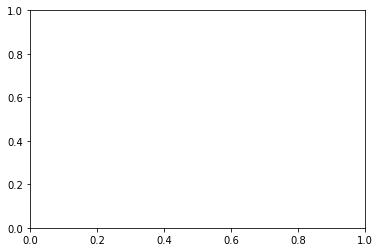

In [229]:
import matplotlib.pyplot as plt
import numpy as np
t = np.linspace(0, 100)

plt.plot(t, f_k0(t))

In [336]:
u_final.diff(X)

Matrix([
[                                                                                                                                                                                                                                                                                                                                                           c3],
[                                                                                                                                                     (2*\dot{\theta}**2*c0*k0*(c0*c2 - c1**2*cos(\theta)**2)*cos(\theta) - 4*\dot{\theta}*c0*c1*sin(\theta) + k0*(\dot{\theta}**2*c0 - 2*c1*g*cos(\theta))*(c0*c2 - c1**2*cos(\theta)**2)*cos(\theta))/(2*c0)],
[                                                                                                                                                                                                                                                                                            

In [136]:
M(X, Z) (DX , DZ) - F(X, Z) = Gu

# min loss
# constraint y^2 + z^2 = 1
# dydt = z * dtheta    (sin(theta))
# dzdt = -y * dtheta   (cos(theta))

Matrix([
[1],
[0],
[0],
[0]])

In [166]:
z_c,z_s = sp.symbols('z_c, z_s')
subs_z = [(sp.sin(theta), z_s), (sp.cos(theta), z_c)]
Mz = sp.eye(5)
Fz = sp.zeros(5,1)
Mz[0:4, 0:4] = M.subs(subs_z)
Fz[0:4,0] = F.subs(subs_z)
Z_list = [dx, dtheta, x, z_s, z_c]
Z = sp.symbols('z:5')

Fz[3,0] = z_c * dtheta
Fz[4,0] = -z_s *dtheta
Gz = sp.zeros(5,1)
Gz[0,0] = 1

Fz = Fz.subs(zip(Z_list, Z))
Mz = Mz.subs(zip(Z_list, Z))
Hz = Z[3]**2 + Z[4]**2 - 1

In [168]:
# Mz(Z) @ Z' - Fz(Z) = G u
# H(z) = 0

# 


Matrix([
[c1*z1**2*z3],
[   -c1*g*z3],
[         z0],
[      z1*z4],
[     -z1*z3]])

In [184]:
Zp = sp.Matrix(sp.symbols(r'\dot{z}_0, \dot{z}_1, \dot{z}_2, \dot{z}_3, \dot{z}_4 '))

Phi_0 = Mz @ Zp - Fz
Phi_u = Phi_0[0]
Phi_0[0] = Hz

In [185]:
Phi_0

Matrix([
[                       z3**2 + z4**2 - 1],
[\dot{z}_0*c1*z4 + \dot{z}_1*c0 + c1*g*z3],
[                          \dot{z}_2 - z0],
[                       \dot{z}_3 - z1*z4],
[                       \dot{z}_4 + z1*z3]])

In [186]:
Phi_u

\dot{z}_0*c2 + \dot{z}_1*c1*z4 + \dot{z}_2*c3 - c1*z1**2*z3

In [239]:
# E = T + (1 + cos(theta))
# Min when 

\dot{\theta}**2*c0/2 - c1*g*(cos(\theta) - 1)

In [ ]:
A.T @ P + P @ A 